In [12]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from pyod.models.iforest import IForest
from pyod.models.dif import DIF
from pyod.models.loda import LODA
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score


# EX 1

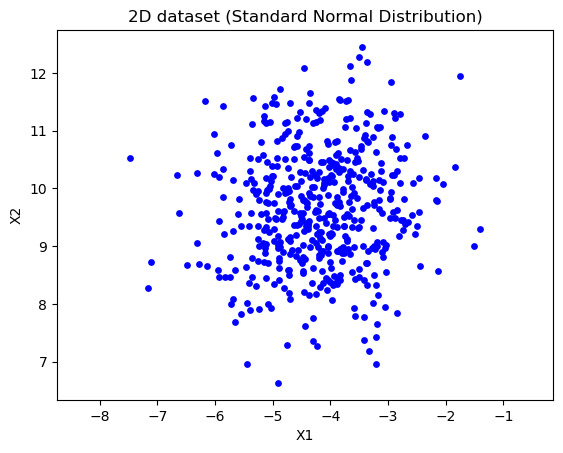

In [3]:

x,_ = make_blobs(
    n_samples=500,
    n_features=2,
    centers=1,
    cluster_std=1.0,
    random_state=9000
)

plt.scatter(x[:, 0], x[:, 1], s=15, color='blue')
plt.title("2D dataset (Standard Normal Distribution)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis('equal')
plt.show()

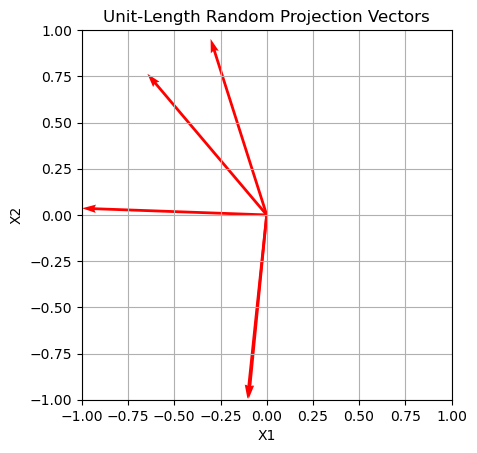

In [4]:
rng = np.random.default_rng(9000)

projection_vectors = rng.multivariate_normal(
    mean=[0,0],
    cov = [[1,0],[0,1]],
    size = 5
)
projection_vectors = projection_vectors / np.linalg.norm(projection_vectors,axis=1)[:,np.newaxis]

origin = np.zeros((5, 2))
plt.quiver(
    origin[:, 0], origin[:, 1],
    projection_vectors[:, 0], projection_vectors[:, 1],
    angles='xy', scale_units='xy', scale=1, color='red'
)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Unit-Length Random Projection Vectors")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


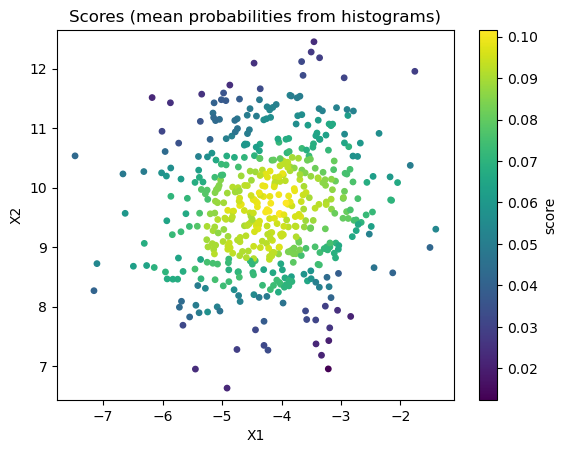

In [5]:

# y = X * W
y = (projection_vectors @ x.T)

def make_hist_with_probs(y, bins=30, pad_ratio=0.1):
    y_min, y_max = np.min(y), np.max(y)

    # Get a bigger range
    range = y_max - y_min
    lo = y_min - pad_ratio * range
    hi = y_max + pad_ratio * range

    counts, bin_edges = np.histogram(y, bins=bins, range=(lo, hi))
    probs = counts.astype(float) / y.size
    return bin_edges, probs

histograms = [make_hist_with_probs(y[i], bins=30, pad_ratio=0.15) for i in range(5)]

def bin_prob_for_sample(x, w, bin_edges, probs):
    y = float(np.dot(x, w))
    idx = np.searchsorted(bin_edges, y, side='right') - 1

    # return 0 probability in case the index exceeds the bins
    if idx < 0 or idx >= len(probs):
        return 0.0
    return probs[idx]


def anomaly_score_mean_prob(x,histograms):
    ps = []
    for i in range(5):
        bin_edges, probs = histograms[i]
        p = bin_prob_for_sample(x, projection_vectors[i], bin_edges, probs)
        ps.append(p)
    return float(np.mean(ps))

scores = np.array([anomaly_score_mean_prob(xx,histograms) for xx in x])


plt.scatter(x[:, 0], x[:, 1], c=scores, s=15)
plt.title("Scores (mean probabilities from histograms)")
plt.xlabel("X1"); plt.ylabel("X2"); plt.axis('equal'); plt.colorbar(label="score")
plt.show()


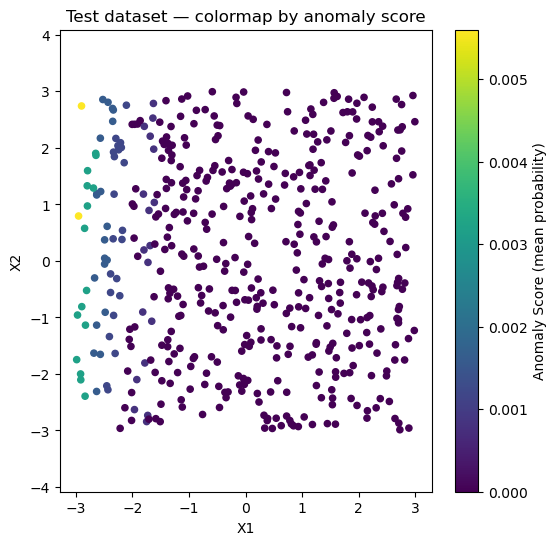

In [6]:
x_test = rng.uniform(low=-3,high=3,size=(500,2))
scores_test = np.array([anomaly_score_mean_prob(x,histograms) for x in x_test])

plt.figure(figsize=(6, 6))
plt.scatter(x_test[:, 0], x_test[:, 1], c=scores_test, cmap='viridis', s=20)
plt.colorbar(label='Anomaly Score (mean probability)')
plt.title("Test dataset — colormap by anomaly score")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis('equal')
plt.show()

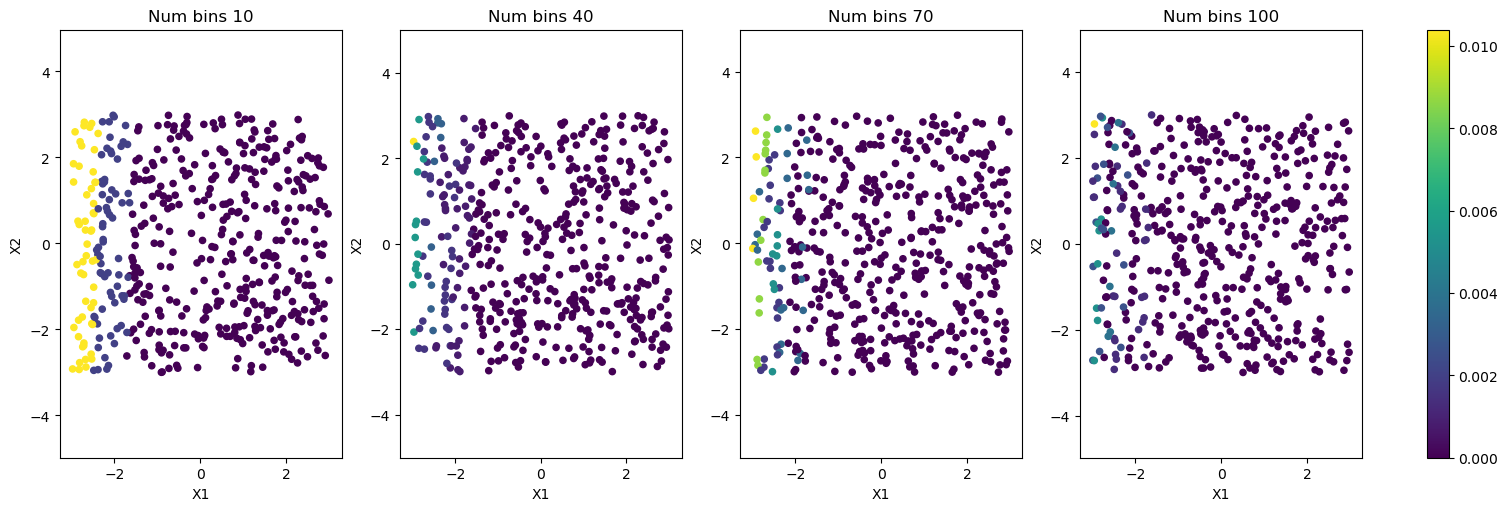

In [7]:
bin_vals  = [10,40,70,100]
fig, axes = plt.subplots(1, len(bin_vals), figsize=(15, 5),constrained_layout=True)

for i,num_bins in enumerate(bin_vals):
    histograms = [make_hist_with_probs(y[i], bins=num_bins, pad_ratio=0.15) for i in range(5)]

    x_test = rng.uniform(low=-3,high=3,size=(500,2))
    scores_test = np.array([anomaly_score_mean_prob(x,histograms) for x in x_test])

    axes[i].scatter(x_test[:, 0], x_test[:, 1], c=scores_test, cmap='viridis', s=20)

    axes[i].set_title(f"Num bins {num_bins}")
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")
    axes[i].axis('equal')


plt.colorbar(axes[0].collections[0], ax=axes, orientation='vertical', fraction=0.025)
plt.show()


# EX 2; 2D

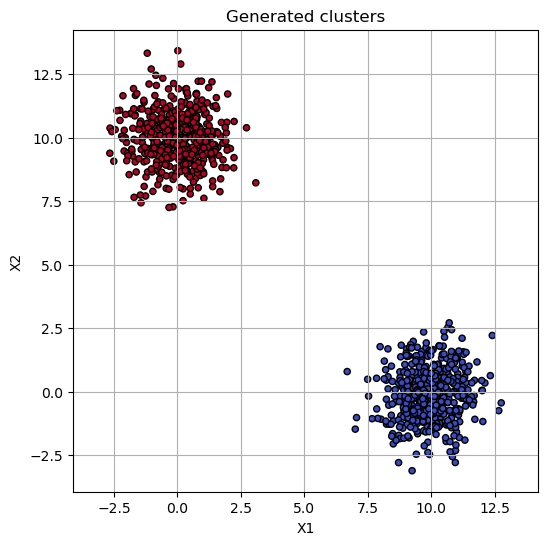

In [8]:
x, y = make_blobs(
    n_samples=[500,500],
    centers=[(10, 0), (0, 10)],
    cluster_std=[1,1],
    n_features=2,
    random_state=9000,
)

x_test = rng.uniform(low=-10,high=20,size=(1000,2))

plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm', s=20, edgecolor='k')
plt.title("Generated clusters")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis('equal')
plt.grid(True)
plt.show()

In [ ]:
iforest_model = IForest(contamination=0.2,random_state=9000)
iforest_model.fit(x)
scores_i_forest = iforest_model.decision_function(x_test)

deep_iforest_model = DIF(contamination=0.2,random_state=9000)
deep_iforest_model.fit(x)
scores_deep_iforest_model = deep_iforest_model.decision_function(x_test)

loda_model = LODA(contamination=0.2)
loda_model.fit(x)
scores_loda_model = loda_model.decision_function(x_test)


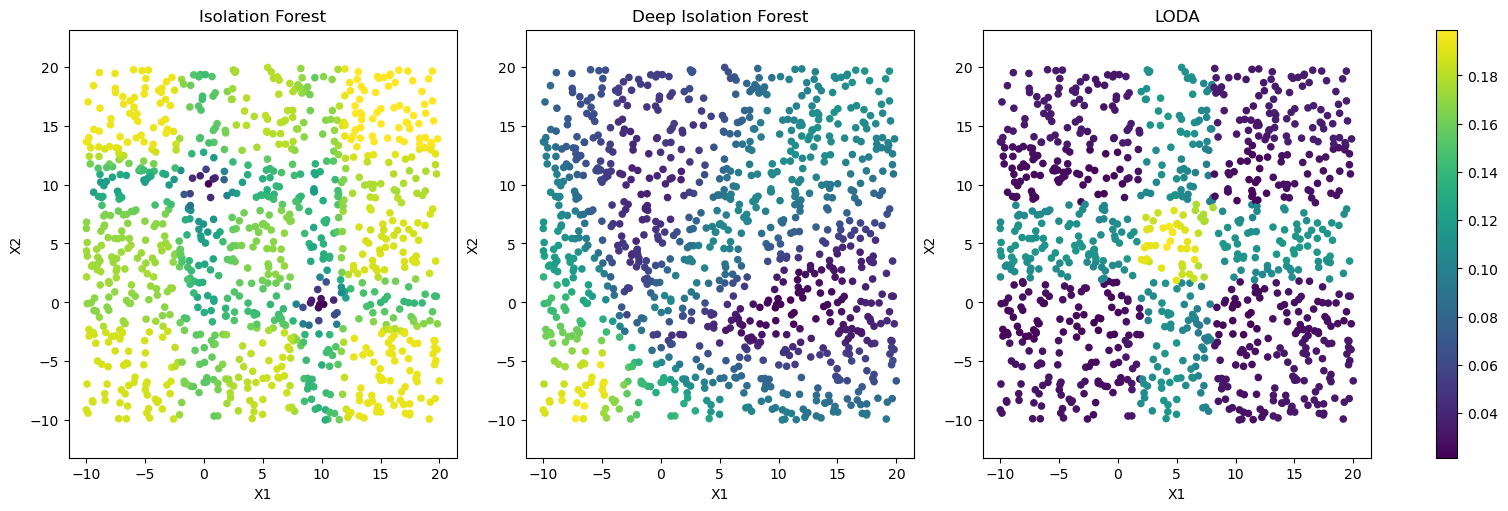

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5),constrained_layout=True)

#Isolation Forest
axes[0].scatter(x_test[:, 0], x_test[:, 1],
                c=scores_i_forest, cmap='viridis', s=20)
axes[0].set_title("Isolation Forest")
axes[0].set_xlabel("X1")
axes[0].set_ylabel("X2")
axes[0].axis('equal')

# Deep Isolation Forest
axes[1].scatter(x_test[:, 0], x_test[:, 1],
                c=scores_deep_iforest_model, cmap='viridis', s=20)
axes[1].set_title("Deep Isolation Forest")
axes[1].set_xlabel("X1")
axes[1].set_ylabel("X2")
axes[1].axis('equal')

# LODA
axes[2].scatter(x_test[:, 0], x_test[:, 1],
                c=scores_loda_model, cmap='viridis', s=20)
axes[2].set_title("LODA")
axes[2].set_xlabel("X1")
axes[2].set_ylabel("X2")
axes[2].axis('equal')

plt.colorbar(axes[2].collections[0], ax=axes, orientation='vertical', fraction=0.025)
plt.show()

/home/gabroveanu-razvan/anaconda3/envs/anomaly/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/gabroveanu-razvan/anaconda3/envs/anomaly/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/gabroveanu-razvan/anaconda3/envs/anomaly/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/gabroveanu-razvan/anaconda3/envs/anomaly/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be 

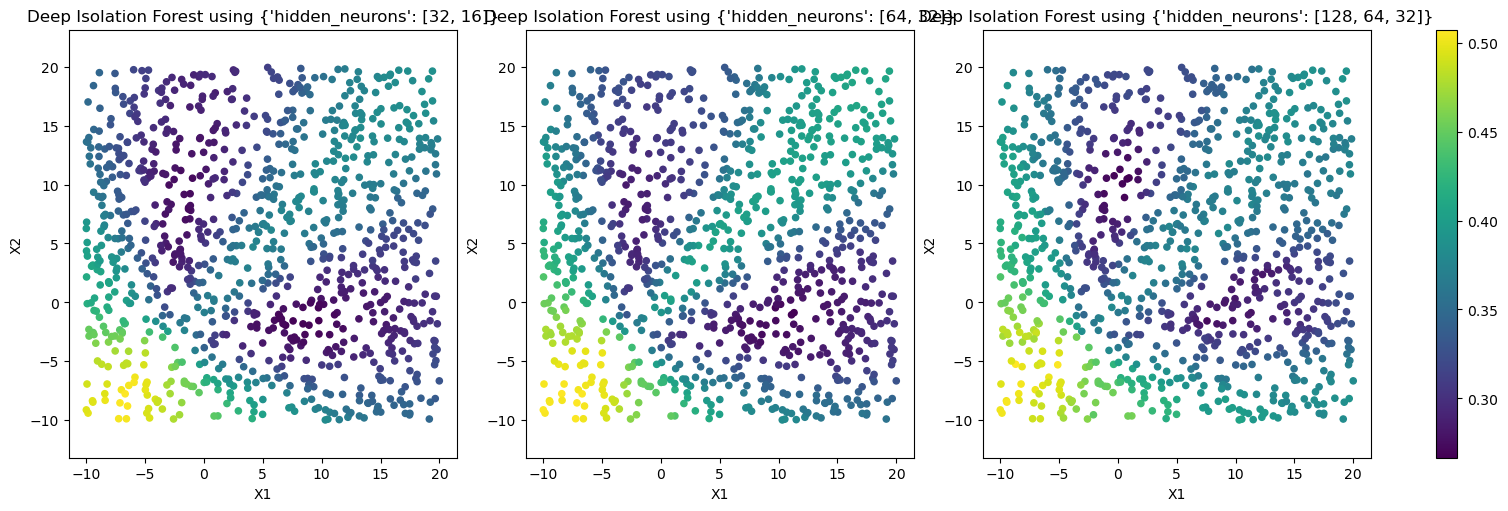

In [14]:
dif_configs = [
    {"hidden_neurons": [32, 16]},
    {"hidden_neurons": [64, 32]},
    {"hidden_neurons": [128, 64, 32]},
]
fig, axes = plt.subplots(1, len(dif_configs), figsize=(15, 5),constrained_layout=True)

for i,cfg in enumerate(dif_configs):
    deep_iforest_model = DIF(contamination=0.2,random_state=9000,**cfg)
    deep_iforest_model.fit(x)
    scores_deep_iforest_model = deep_iforest_model.decision_function(x_test)

    axes[i].scatter(x_test[:, 0], x_test[:, 1],
                c=scores_deep_iforest_model, cmap='viridis', s=20)
    axes[i].set_title(f"Deep Isolation Forest using {cfg}")
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")
    axes[i].axis('equal')

plt.colorbar(axes[2].collections[0], ax=axes, orientation='vertical', fraction=0.025)
plt.show()



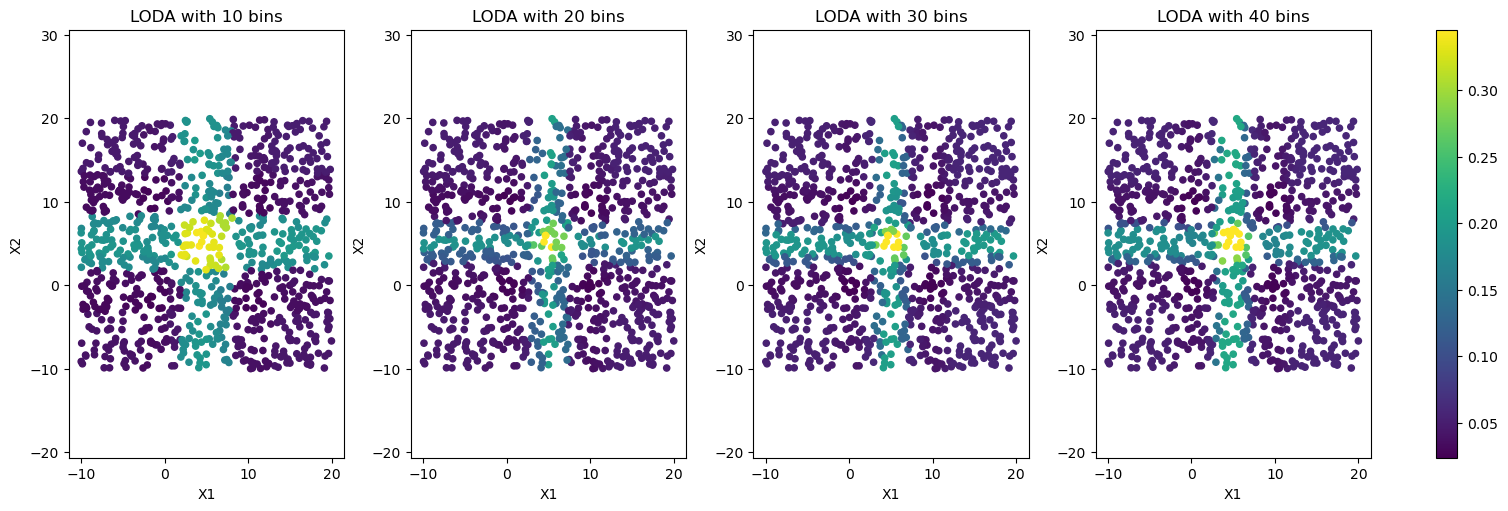

In [12]:

bin_vals = [10,20,30,40]
fig, axes = plt.subplots(1, len(bin_vals), figsize=(15, 5),constrained_layout=True)

for i,bins in enumerate(bin_vals):
    loda_model = LODA(contamination=0.2,n_bins=bins)
    loda_model.fit(x)
    scores_loda_model = loda_model.decision_function(x_test)
    # LODA
    axes[i].scatter(x_test[:, 0], x_test[:, 1],
                    c=scores_loda_model, cmap='viridis', s=20)
    axes[i].set_title(f"LODA with {bins} bins")
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")
    axes[i].axis('equal')

plt.colorbar(axes[2].collections[0], ax=axes, orientation='vertical', fraction=0.025)
plt.show()



# EX3

In [33]:
data= loadmat("shuttle.mat")
x = data["X"]
y = data["y"].ravel().astype(int)

def ex3(x,y,random_state):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.4,random_state=random_state)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_train_bin = (y_train != 1).astype(int)
    y_test_bin  = (y_test  != 1).astype(int)

    # 1) IForest
    iforest_model = IForest(contamination=0.02, random_state=9000)
    iforest_model.fit(x_train)

    # 2) LODA
    loda_model = LODA(contamination=0.02)
    loda_model.fit(x_train)

    # 3) DIF
    deep_iforest_model = DIF(contamination=0.02, random_state=9000)
    deep_iforest_model.fit(x_train)

    pred_if = iforest_model.predict(x_test)
    pred_loda = loda_model.predict(x_test)
    pred_dif = deep_iforest_model.predict(x_test)

    score_if = -iforest_model.decision_function(x_test)
    score_loda = loda_model.decision_function(x_test)
    score_dif = -deep_iforest_model.decision_function(x_test)

    return [
        (
            balanced_accuracy_score(y_test_bin, pred_loda),
            roc_auc_score(y_test_bin, score_loda),
        ),
        (
            balanced_accuracy_score(y_test_bin, pred_if),
            roc_auc_score(y_test_bin, score_if)
        ),
        (
            balanced_accuracy_score(y_test_bin, pred_dif),
            roc_auc_score(y_test_bin, score_dif)
        ),
    ]




In [ ]:

ba_scores = [[],[],[]]
roc_scores = [[],[],[]]

states = list(range(10))

for state in states:
    res = ex3(x,y,state)
    #loda
    ba_scores[0].append(res[0][0])
    roc_scores[0].append(res[0][1])
    #if
    ba_scores[1].append(res[1][0])
    roc_scores[1].append(res[1][1])
    #dif
    ba_scores[2].append(res[2][0])
    roc_scores[2].append(res[2][1])


In [35]:
ba_scores = np.array(ba_scores)
roc_scores = np.array(roc_scores)

avg_ba = np.mean(ba_scores, axis=1)
avg_ro = np.mean(roc_scores, axis=1)

print(avg_ba)
print(avg_ro)


[0.50595765 0.36483313 0.49802587]
[0.65404362 0.99714022 0.97313229]
